<h2>
Pairs Trading
</h2>
<p>
The Jupyter notebook explores pairs trading stratagies.
This document is available on the GitHub repository https://github.com/IanLKaplan/pairs_trading
</p>
<blockquote>
<p>
Pairs trading is an approach that takes advantage of the
mispricing between two (or more) co-moving assets, by
taking a long position in one (many) and shorting the
other(s), betting that the relationship will hold and that
prices will converge back to an equilibrium level.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> availabel from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading is sometimes referred to as a statistical arbitrage trading strategy.
</p>
<blockquote>
<p>
Statistical arbitrage and pairs trading tries to solve this problem using price relativity. If two assets share the same
characteristics and risk exposures, then we can assume that their behavior would be similar as well. This has
the benefit of not having to estimate the intrinsic value of an asset but rather just if it is under or overvalued
relative to a peer(s). We only have to focus on the relationship between the two, and if the spread happens
to widen, it could be that one of the securities is overpriced, the other is underpriced, or the mispricing is a
combination of both.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> availabel from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading algorithms have been reported to yield portfolios with Sharpe ratios in excess of 1.0 and returns of 10% or
higher. Pairs trading takes both long and short positions, so the portfolio tends to be market neutral. A pairs trading portfolio
can have drawdowns, but the drawdowns should be less than a benchmark like the S&P 500 because of the market neutral nature of the
portfolio.
</p>
<p>
Markets tend toward efficiency and many quantitative approaches fade over time as they are adopted by hedge funds. Pairs trading
goes back to the mid-1980s. Surprisingly, the approach still seems to be profitable. One reason for this could be that there are a vast
number of possible pairs and the pairs portfolio's tend to be fairly small (5 to 20 pairs, in most cases). This could
leave unexploited pairs in the market. Pairs trading may also be difficult to scale to a level that would be attractive to institutional
traders, like hedge funds, so the strategy has not been arbitraged out of the market.
</p>
<p>
Mathematical finance often uses models that are based on normal distributions, constant means and standard deviations. Actual market
data is often not normally distributed and changes constantly. The statistics used to select stocks for pairs trading makes an assumption
that the pair distribution has a constant mean and standard deviation. This assumption holds, at best, over a window of time.
</p>
<p>
The statistics that predict a successful pair will not be accurate in all time periods. For the strategy to be successful, the predicition
must be right more often than not. To minimize the risk in any particular trade, this suggests that trading a larger portfolio will
be more successful than trading a small portfolio.
</p>
<h3>
Overview
</h3>
<p>
The primary references used for this notebook are the books <i>Pairs Trading</i> by Ganapathy Vidyamurthy and <i>Algorithmic
Trading</i> by Ernest P. Chan.
</p>
<p>
The pairs trading strategy attempts to find a pair of stocks that, together, form a mean reverting time series.
</p>
<p>
Implementing the pairs trading strategy involves two logical steps:
</p>
<ol>
<li>
<p>
Pairs selection: Identify a pair of stocks that are likely to have mean reverting behavior using a lookback period.
</p>
</li>
<li>
<p>
Trading the stocks using the long/short strategy over the trading period. This involves building a trading signal
from the close prices of the stock pair. When the trading signal is above or below the mean at some threshold value
a long and short position are taken in the two stocks.
</p>
</li>
</ol>
<h2>
Pairs Selection
</h2>
<h3>
S&P 500 Industry Sectors
</h3>
<p>
Pairs are selected from the S&P 500 stock universe. These stocks are have a high trading volume, with a small bid-ask spread. These stocks
are also easier to short, with lower borrowing fees.
</p>
<p>
In pairs selection we are trying to find pairs that are cointegrated and have mean reverting behavior. The stock pairs should
have some logical connection. In the book <i>Pairs Trading</i> the author discusses using factor models to select pairs with
similar factor characteristics. A simpler approach is to select pairs from a common S&P 500 sector. This will tend to
select stocks with similar behavior, while reducing the universe of stocks from which pairs are selected.
</p>
<p>
Reducing the universe of stock pairs is important because, even with modern computing power, it would be difficult
to test all possible stock pairs in the S&P 500, since the number of pairs grows exponentially with N, the number of stocks.
</p>

\$ number \space of \space pairs = \frac{N^2 - N}{2} $

<p>
The S&P 500 component stocks (in 2022) and their related industries have been downloaded from barchart.com.  The files are included in this
GitHub repository.
</p>
<p>
The S&P 500 sectors are:
</p>
<ol>
<li>
Consumer discressionary
</li>
<li>
Consumer staples
</li>
<li>
Energy
</li>
<li>
Financials
</li>
<li>
Health care
</li>
<li>
Industrials
</li>
<li>
Info tech
</li>
<li>
Materials
</li>
<li>
Real estate
</li>
<li>
Communication services
</li>
<li>
Utilities
</li>
</ol>
<h3>
Stock Market Close Data
</h3>
<p>
The data used to model pairs trading in this notebook uses close price data for all of the S&P 500 stocks from the start date to yesterday
(e.g., one day in the past). In other models (see Stock Market Cash Trigger and ETF Rotation) the stock data was downloaded the first time the
notebook was run and stored in temporary files.  In these notebooks the first notebook run incurred the initial overhead of downloading
the data, but subsequent runs could read the data from local temporary files.
</p>
<p>
Downloading all of the close price data every day would have a high overhead for the S&P 500 stocks. To avoid this, the
data is downloaded once and stored in local files. When the notebook is run at later times, only the data between the
end of the last date in the file and the current end date will be downloaded.
</p>
<p>
There are stocks in the S&P 500 list that were listed on the stock exchange later than the start date.  These
stocks are filtered out, so the final stock set does not include all of the S&P 500 stocks.
</p>
<p>
Filtering stocks in this way can create a survivorship bias. This should not be a problem for back testing pairs trading
algorithms through the historical time period. The purpose of this backtest is to understand the pairs trading behavior.
The results do not depend on the stock universe, only on the pairs selected.
</p>


In [23]:
import os
from datetime import datetime
from multiprocessing import Pool
from typing import List, Tuple, Set

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy import log
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

from plot_ts.plot_time_series import plot_ts, plot_two_ts
#
# Local libraries
#
from read_market_data.MarketData import MarketData
from utils.find_date_index import findDateIndex

# Apply the default theme
sns.set_theme()

s_and_p_file = 's_and_p_sector_components/sp_stocks.csv'
s_and_p_data = 's_and_p_data'
start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)

trading_days = 252


def read_s_and_p_stock_info(path: str) -> pd.DataFrame:
    """
    Read a file containing the information on S&P 500 stocks (e.g., the symbol, company name and sector)
    :param path: the path to the file
    :return: a DataFrame with columns Symbol, Name and Sector
    """
    s_and_p_stocks = pd.DataFrame()
    if os.access(path, os.R_OK):
        # s_and_p_socks columns are Symbol, Name and Sector
        s_and_p_stocks = pd.read_csv(s_and_p_file, index_col=0)
        new_names = [sym.replace('.', '-') for sym in s_and_p_stocks['Symbol']]
        s_and_p_stocks['Symbol'] = new_names
    else:
        print(f'Could not read file {s_and_p_file}')
    return s_and_p_stocks


def extract_sectors(stocks_df: pd.DataFrame) -> dict:
    """
    Columns in the DataFrame are Symbol,Name,Sector
    :param stocks_df:
    :return: a dictionary where the key is the sector and the value is a list of stock symbols in that sector.
    """
    sector: str = ''
    sector_l: list = list()
    stock_sectors = dict()
    for t, stock_info in stocks_df.iterrows():
        if sector != stock_info['Sector']:
            if len(sector_l) > 0:
                stock_sectors[sector] = sector_l
                sector_l = list()
            sector = stock_info['Sector']
        sector_l.append(stock_info['Symbol'])
    stock_sectors[sector] = sector_l
    return stock_sectors


def calc_pair_counts(sector_info: dict) -> pd.DataFrame:
    """
    Return a DataFrame
    :param sector_info: a dictionary where the key is the sector name and the
                        value is a list of stock symbols for that sector
    :return: a DataFrame where the index is the sector names and the columns are "num stocks" and "num pairs"
             "num stocks" is the number of stocks in the sector. "num pairs" is the number of unique pairs
             that can be formed from the set of sector stocks.  The last row is the sum of the columns.
    """
    column_label = ['num stocks', 'num pairs']
    sectors = list(sector_info.keys())
    counts_l: list = list()
    n_l: list = list()
    for sector in sectors:
        n = len(sector_info[sector])
        n_l.append(n)
        count = ((n ** 2.0) - n) / 2.0
        counts_l.append(count)
    num_stocks = sum(n_l)
    info_df = pd.DataFrame(n_l)
    info_df = pd.concat([info_df, pd.DataFrame(counts_l)], axis=1)
    info_df.columns = column_label
    sum_pairs = sum(counts_l)
    num_stocks_df = pd.DataFrame([num_stocks])
    sum_df = pd.DataFrame([sum_pairs])
    row_df = pd.concat([num_stocks_df, sum_df], axis=1)
    row_df.columns = column_label
    info_df = pd.concat([info_df, row_df], axis=0)
    sectors.append('Sum')
    info_df.index = sectors
    return info_df


# stock_info_df: a DataFrame with columns Symbol, Name, Sector
stock_info_df = read_s_and_p_stock_info(s_and_p_file)
stock_l: list = list(set(stock_info_df['Symbol']))
stock_l.sort()
market_data = MarketData(start_date=start_date, path=s_and_p_data)

# Get close prices for the S&P 500 list
close_prices_df = market_data.get_close_data(stock_l)
final_stock_list = list(close_prices_df.columns)
mask = stock_info_df['Symbol'].isin(final_stock_list)
# Some stocks were listed on the stock exchange later than start_date. In this case the stock will not
# be returned by MarketData.get_close_data(). final_stock_info has the Symbol, Name, Sector for the
# set of stocks that it was possible to obtain close prices for the date range.
final_stock_info_df = stock_info_df[mask]

sectors = extract_sectors(final_stock_info_df)
pairs_info_df = calc_pair_counts(sectors)


<p>
The table below shows the number of unique pairs for each S&P 500 sector and the total number of pairs. By drawing pairs from sectors,
rather than the whole S&P 500 set of stocks, the number of possible pairs is reduced from 124,750.
</p>

In [24]:
print(tabulate(pairs_info_df, headers=[*pairs_info_df.columns], tablefmt='fancy_grid'))

╒════════════════════════╤══════════════╤═════════════╕
│                        │   num stocks │   num pairs │
╞════════════════════════╪══════════════╪═════════════╡
│ information-technology │           55 │        1485 │
├────────────────────────┼──────────────┼─────────────┤
│ communication-services │           18 │         153 │
├────────────────────────┼──────────────┼─────────────┤
│ energies               │           16 │         120 │
├────────────────────────┼──────────────┼─────────────┤
│ utilities              │           25 │         300 │
├────────────────────────┼──────────────┼─────────────┤
│ real-estate            │           28 │         378 │
├────────────────────────┼──────────────┼─────────────┤
│ consumer-discretionary │           47 │        1081 │
├────────────────────────┼──────────────┼─────────────┤
│ financials             │           58 │        1653 │
├────────────────────────┼──────────────┼─────────────┤
│ industrials            │           58 │       

<h3>
Lookback Time Period
</h3>
<p>
Pairs are selected for trading using a lookback period. The longer the lookback period (with more data points) the
less error there will be in the selection statistics, assuming that the data is stable
(e.g., constant mean and standard deviation).  Stock price time series are not stable over time, however. The mean and the
standard deviation changes, as do other statistics like correlation and mean reversion.
</p>
<p>
In using a lookback period to choose trading pairs we are making the assumption that the past
will resemble the future trading period. The longer the lookback period, the less likely it is that the statistics will match
the trading period. This creates a tension between statistical accuracy and statistics that are more likely to reflect
the future trading period.
</p>
<p>
A half year period is used for the lookback period. In practice the statistics for a year period (252 trading days) and a
six month period (126 trading days) seem to be similar. We assume that the six month period will more accurately resemble the
future trading period.
</p>

<h2>
Correlation
</h2>
<p>
Stocks that are strongly correlated are more likely to also exhibit mean reversion since they have similar market behavior.
This section examines the correlation distribution for the S&P 500 sector pairs.
</p>
<p>
After selecting stocks based on their industry sector, the next filter used is the pair correlation of the
natural log of the close prices.
</p>


In [25]:

def get_pairs(sector_info: dict) -> List[Tuple]:
    """
    Return the sector stock pairs, where the pairs are selected from the S&P 500 sector.

    :param sector_info: A dictionary containing the sector info. For example:
                        energies': ['APA', 'BKR', 'COP', ...]
                       Here 'energies' is the dictionary key for the S&P 500 sector. The dictionary value is the
                       list of stocks in the sector.

    :return: A list of Tuples, where each tuple contains the symbols for the stock pair and the sector.
            For example:
              [('AAPL', 'ACN', 'information-technology'),
               ('AAPL', 'ADBE', 'information-technology'),
               ('AAPL', 'ADI', 'information-technology'),
               ('AAPL', 'ADP', 'information-technology'),
               ('AAPL', 'ADSK', 'information-technology')]
    """
    pairs_list = list()
    sectors = list(sector_info.keys())
    for sector in sectors:
        stocks = sector_info[sector]
        num_stocks = len(stocks)
        for i in range(num_stocks):
            stock_a = stocks[i]
            for j in range(i + 1, num_stocks):
                stock_b = stocks[j]
                pairs_list.append((stock_a, stock_b, sector))
    return pairs_list


def calc_pair_correlation(stock_close_df: pd.DataFrame, pair: Tuple, window: int) -> pd.Series:
    """
    Calculate the windowed correlations for a stock pair over the entire data set.
    :param stock_close_df: A data frame containing the stock close prices
    :param pair: the stock pair (e.g., a Tuple consisting of two strings for the stock symbols)
    :param window: The data window
    :return: a numpy array of windowed correlations for the pair over the entire time period.
    """
    window = int(window)
    cor_v = np.zeros(0)
    stock_a = pair[0]
    stock_b = pair[1]
    a_close = stock_close_df[stock_a]
    b_close = stock_close_df[stock_b]
    a_log_close = log(a_close)
    b_log_close = log(b_close)

    index = stock_close_df.index
    date_l: List = []
    assert len(a_log_close) == len(b_log_close)
    for i in range(0, len(a_log_close), window):
        sec_a = a_log_close[i:i + window]
        sec_b = b_log_close[i:i + window]
        c = np.corrcoef(sec_a, sec_b)
        cor_v = np.append(cor_v, c[0, 1])
        date_l.append(index[i])
    cor_s: pd.Series = pd.Series(cor_v)
    cor_s.index = date_l
    return cor_s


def calc_windowed_correlation(stock_close_df: pd.DataFrame, pairs_list: List[Tuple], window: int) -> np.array:
    """
    Calculate the windowed pair correlation over the entire time period, for all the pairs.

    :param stock_close_df: A data frame containing the stock close prices. The columns are the stock tickers.
    :param pairs_list: A list of the pairs formed from the S&P 500 sectors.
    :param window: the window over which the correlation is calculated.
    :return: A numpy array with the correlations.
    """
    window = int(window)
    all_cor_v = np.zeros(0)
    for pair in pairs_list:
        cor_v: np.array = calc_pair_correlation(stock_close_df, pair, window)
        all_cor_v = np.append(all_cor_v, cor_v)
    return all_cor_v


def display_histogram(data_v: np.array, x_label: str, y_label: str) -> None:
    num_bins = int(np.sqrt(data_v.shape[0])) * 4
    fix, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.hist(data_v, bins=num_bins, color="blue", ec="blue")
    plt.show()


lookback_window = int(trading_days / 2)
apple_tuple: Tuple = ('AAPL', 'MPWR')
apple_tuple_cor_s = calc_pair_correlation(stock_close_df=close_prices_df, pair=apple_tuple, window=lookback_window)


<p>
The lookback period for pairs selection is six months (126 trading days). As a first step, all of the S&P 500 sector
pairs will be tested for correlation over the lookback period.
</p>
<p>
Correlation is calculated on the log of the price for each stock pair.
</p>
<p>
The windowed correlation is not stable. The plot below shows the correlation between two stocks, AAPL and MPWR, over windowed
periods from the start date.
</p>

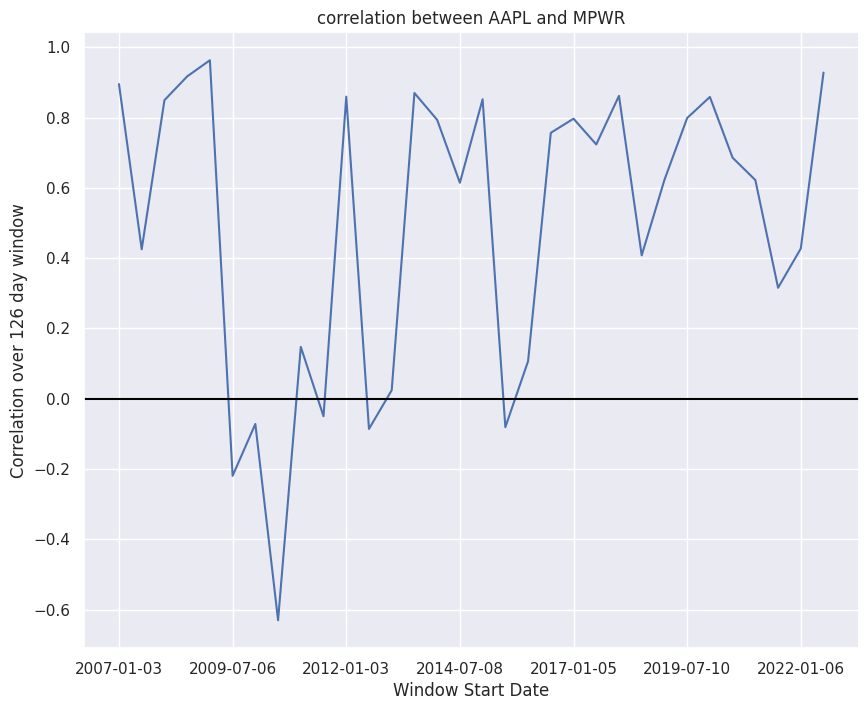

In [26]:

plot_ts(data_s=apple_tuple_cor_s, title=f'correlation between {apple_tuple[0]} and {apple_tuple[1]}',
        x_label='Window Start Date', y_label=f'Correlation over {lookback_window} day window')


<p>
Since correlation is not stable, a stock pair that is highly correlated in one time period be uncorrelated (or negatively
correlated) in another time period.
</p>
<p>
The histogram below shows the aggregate distribution of the pair correlation over all half year time periods.
</p>

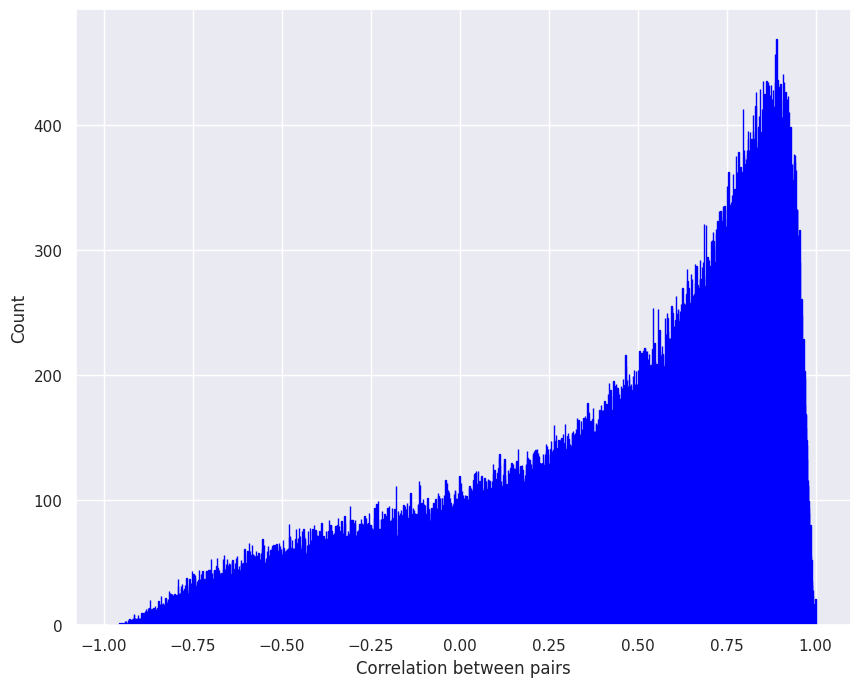

In [27]:

pairs_list = get_pairs(sectors)

cor_a = calc_windowed_correlation(close_prices_df, pairs_list, lookback_window)
display_histogram(cor_a, 'Correlation between pairs', 'Count')


<p>
There are a small number of pairs that have a strong negative correlation (a negative correlation -0.75 to approximately -0.9).
Initially we look at pairs that have a strong positive correlation, but it may be unwise to ignore the negative correlations as
well.
</p>

In [28]:
class WindowedCorrelationDist:

    def __init__(self,
                 stock_close_df: pd.DataFrame,
                 pairs_list: List[Tuple],
                 window: int,
                 cutoff: float):
        self.stock_close_df = stock_close_df
        self.window = window
        self.cutoff = cutoff
        self.pairs_list = pairs_list

    def window_correlation(self, start_ix: int) -> int:
        count = 0
        for pair in self.pairs_list:
            stock_a = pair[0]
            stock_b = pair[1]
            price_a = self.stock_close_df[stock_a].iloc[start_ix:start_ix + self.window]
            price_b = self.stock_close_df[stock_b].iloc[start_ix:start_ix + self.window]
            log_price_a = log(price_a)
            log_price_b = log(price_b)
            c = np.corrcoef(log_price_a, log_price_b)
            if c[0, 1] >= self.cutoff:
                count = count + 1
        return count

    def calc_correlation_dist(self) -> pd.Series:
        start_list = [ix for ix in range(0, self.stock_close_df.shape[0], self.window)]
        with Pool() as mp_pool:
            count_l = mp_pool.map(self.window_correlation, start_list)
        dist_s = pd.Series(count_l)
        index = self.stock_close_df.index
        dist_s.index = index[start_list]
        return dist_s

correlation_cutoff = 0.75
cor_dist_obj = WindowedCorrelationDist(stock_close_df=close_prices_df, pairs_list=pairs_list, window=lookback_window,
                                       cutoff=correlation_cutoff)
cor_dist = cor_dist_obj.calc_correlation_dist()

<p>
The plot below shows the number of pairs, in a half year time period period, with a correlation above a particular cutoff.
</p>

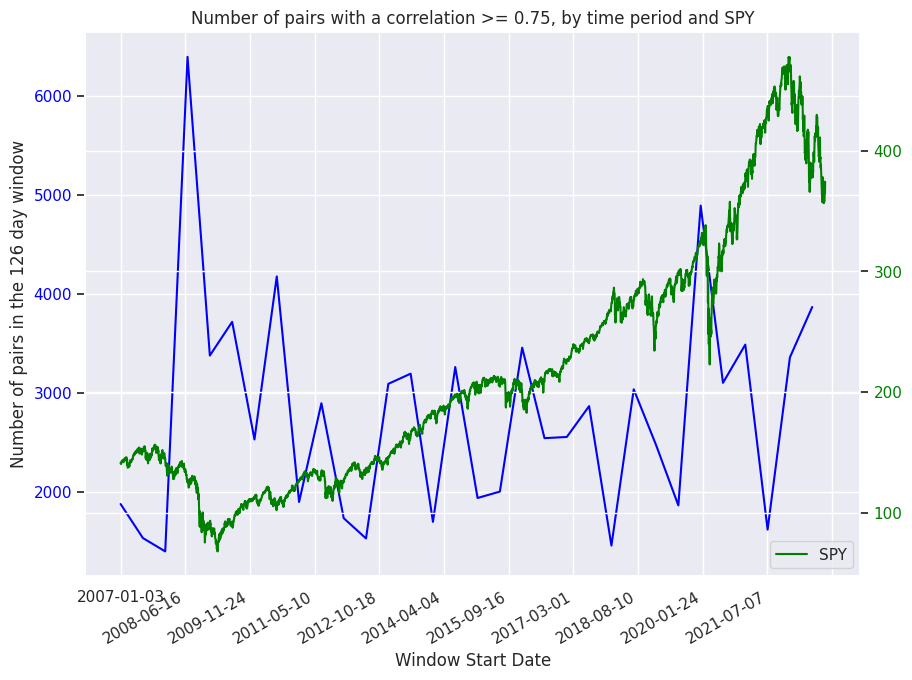

In [29]:

spy_close_df = market_data.read_data('SPY')
spy_close_s = spy_close_df[spy_close_df.columns[0]]
spy_close_s.columns = spy_close_df.columns
cor_dist.columns = ['Correlation']
plot_two_ts(data_a=cor_dist, data_b=spy_close_s, title=f"Number of pairs with a correlation >= {correlation_cutoff}, by time period and SPY",
        x_label='Window Start Date', y_label=f'Number of pairs in the {lookback_window} day window')

<p>
In the plot above, about 75% of the pairs are highly correlated around 2008. The corresponds to the 2008-2009 stock market crash
caused by the financial crisis. This lends validity to the financial market maxim that in a market crash, assets become correlated.
</p>
<p>
To the extent that correlation is a predictor for mean reversion, this also suggests that mean reversion statistics may be volatile.
</p>


In [30]:
def simple_return(time_series: np.array, period: int = 1) -> List:
    return list(((time_series[i] / time_series[i - period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df

def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros(return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = np.array(return_df.values)
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i - 1] + port_a[i - 1] * return_a[i - 1]
    return port_a

def calc_holding_return(close_prices_df: pd.DataFrame, symbol: str, start_ix: int, end_ix: int, holding: int) -> pd.DataFrame:
    stock_df = pd.DataFrame(close_prices_df[symbol].iloc[start_ix:end_ix])
    stock_ret = return_df(stock_df)
    holding_ret_df = pd.DataFrame(apply_return(holding, stock_ret))
    holding_ret_df.columns = [symbol]
    holding_ret_df.index = stock_df.index
    return holding_ret_df


class PairStats:
    """
    A container for information about a pair
    """

    def __init__(self,
                 stock_a: str,
                 stock_b: str,
                 cor_v: float,
                 slope: float,
                 intercept: float,
                 residuals: pd.Series,
                 adf_stat: float,
                 p_value: float,
                 critical_vals: dict):
        self.stock_a = stock_a
        self.stock_b = stock_b
        self.cor_v = cor_v
        self.slope = slope
        self.intercept = intercept
        self.residuals = residuals
        self.adf_stat = adf_stat
        self.p_value = p_value
        self.critical_vals = critical_vals

    def __str__(self):
        s1: str = f'({self.stock_a},{self.stock_b}) cor_v: {self.cor_v} slope: {self.slope} intercept: {self.intercept}'
        s2: str = f'adf: {self.adf_stat} p-value: {self.p_value}'
        s3: str = f'1%: {self.critical_vals["1%"]}, 5%: {self.critical_vals["5%"]}, 10%: {self.critical_vals["10%"]}'
        s = s1 + '\n' + s2 + '\n' + s3
        return s


class PairsSelection:
    decimals = 4

    def __init__(self,
                 close_prices: pd.DataFrame,
                 correlation_cutoff: float):
        self.correlation_cutoff = correlation_cutoff
        self.close_prices = close_prices

    def pairs_correlation(self,
                          start_ix: int,
                          end_ix: int,
                          pairs_list: List[Tuple]) -> List[Tuple]:

        """
        Find the pairs with a log(price) correlation greater than or equal to cutoff within a close price window
        from start_ix to end_ix
        :param start_ix: the start index in stock_close_df
        :param end_ix: the end index in stock_close_df
        :param pairs_list: a list of pairs
        :return: A list of tuples consisting of tuple[stock_a, stock_b, sector, correlation]
        """
        selected_pairs_l = list()
        for pair in pairs_list:
            stock_a: str = pair[0]
            stock_b: str = pair[1]
            log_close_a = log(self.close_prices[stock_a][start_ix:end_ix + 1])
            log_close_b = log(self.close_prices[stock_b][start_ix:end_ix + 1])
            c = np.corrcoef(log_close_a, log_close_b)
            cor_v = round(c[0, 1], 2)
            if cor_v >= self.correlation_cutoff:
                sector = pair[2]
                selected_pairs_l.append((stock_a, stock_b, sector, cor_v))
        return selected_pairs_l

    def stationary_analysis(self, start_ix: int, end_ix: int, pair: Tuple) -> PairStats:
        stock_a: str = pair[0]
        stock_b: str = pair[1]
        cor_v: float = pair[3]
        log_close_a = log(self.close_prices[stock_a][start_ix:end_ix])
        log_close_b = log(self.close_prices[stock_b][start_ix:end_ix])
        log_close_b_const = sm.add_constant(log_close_b)
        result_ab = sm.OLS(log_close_a, log_close_b_const).fit()
        log_close_a_const = sm.add_constant(log_close_a)
        result_ba = sm.OLS(log_close_b, log_close_a_const).fit()
        slope_ab = result_ab.params[stock_b]
        slope_ba = result_ba.params[stock_a]
        result = result_ab
        slope = slope_ab
        if slope_ab < slope_ba:
            result = result_ba
            slope = slope_ba
        intercept = round(result.params['const'], self.decimals)
        slope = round(slope, self.decimals)
        residuals = result.resid
        # References
        # https://machinelearningmastery.com/time-series-data-stationary-python/
        # https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II/
        # p-value <= 0.05 stationary mean reverting TS
        # ADF more negative means a stronger mean reverting process
        adf_result: tuple = adfuller(residuals)
        adf_stat = round(adf_result[0], self.decimals)
        p_value = round(adf_result[1], self.decimals)
        critical_vals = adf_result[4]
        pair_stats = PairStats(stock_a=stock_a,
                               stock_b=stock_b,
                               cor_v=cor_v,
                               slope=slope,
                               intercept=intercept,
                               residuals=residuals,
                               adf_stat=adf_stat,
                               p_value=p_value,
                               critical_vals=critical_vals)
        return pair_stats

    def select_pairs(self, start_ix: int, end_ix: int, pairs_list: List[Tuple], threshold: str) -> List[PairStats]:
        """

        :param start_ix: start index in close price DataFrame
        :param end_ix:  end index in close price DataFrame
        :param pairs_list: a list of tuples (stock_a, stock_b, sector)
        :param threshold: a string equal to '1%', '5%' or '10%'
        :return: pairs that are correlated and have regression residuals that show mean reversion to the threshold level
                 Only unique pairs of stocks are returned. If there are two canidate pairs that both have AAPL, for example,
                 only one pair will be returned so that a stock does not appear twice in the set of pairs.
        """
        selected_pairs = self.pairs_correlation(start_ix=start_ix, end_ix=end_ix, pairs_list=pairs_list)

        stock_set: Set = set()
        pair_stat_l: List[PairStats] = list()
        for pair in selected_pairs:
            stats_ = self.stationary_analysis(start_ix=start_ix, end_ix=end_ix, pair=pair)
            threshold_level = stats_.critical_vals[threshold]
            if stats_.adf_stat < threshold_level:
                stock_a: str = pair[0]
                stock_b: str = pair[1]
                if stock_a not in stock_set and stock_b not in stock_set:
                    stock_set.add(stock_a)
                    stock_set.add(stock_b)
                    pair_stat_l.append(stats_)
        return pair_stat_l


d2008_start_date_str = '2008-01-03'
d2008_start_date: datetime = datetime.fromisoformat(d2008_start_date_str)
d2008_start_ix = findDateIndex(close_prices_df.index, d2008_start_date)

pair_df = close_prices_df[['AAPL', 'MPWR']].iloc[d2008_start_ix:d2008_start_ix + lookback_window]

aapl_s = pair_df['AAPL']
mpwr_s = pair_df['MPWR']
log_aapl_s = log(aapl_s)
log_mpwr_s = log(mpwr_s)
c = np.corrcoef(log_aapl_s, log_mpwr_s)
aapl_mpwr_cor = round(c[0, 1], 2)

pairs_selection = PairsSelection(close_prices=close_prices_df, correlation_cutoff=correlation_cutoff)
aapl_mpwr_pair = ('AAPL', 'MPWR', 'information-technology', aapl_mpwr_cor)
pair_stats_2008 = pairs_selection.stationary_analysis(start_ix=d2008_start_ix, end_ix=d2008_start_ix+lookback_window, pair=aapl_mpwr_pair)


<h2>
Mean Reversion
</h2>
<p>
In selecting stock pairs we are looking for a stock pair that, when combined, is stationary and mean reverting. A stationary time series
is a time series that has a constant mean and standard deviation.
</p>
<p>
Stock price time series are rarely (if ever) stationary. Two stock price series can be combined, so that the combination is
stationary. In the case of pairs trading, we add the additional requirement that they combined series are mean reverting.
</p>

\$  m = P_A - \beta P_B $

<p>
In the above equation <i>m</i> is the stationary mean reverting time series, P<sub>A</sub> is the price series for stock A,
P<sub>B</sub> is the price series for stock B and β is the weight factor (for one share of stock A there will be β shares of
stock B).
</p>
<p>
When <i>m</i> is above the mean at some level (perhaps one standard deviation), a short position will be taken in stock A
and a long position will be taken in stock B.  When <i>m</i> is below the mean at some level (perhaps one standard deviation)
a long position will be taken in stock A and a short position will be taken in stock B. The position taken in stock B will be
larger than the postion in stock A by a factor of β.
</p>
<p>
In identifying a pair for pairs trading a determination is made on whether <i>m</i> is mean reverting.  The process of determining
mean reversion will also provide the value of β.
</p>
<h2>
Testing for Mean Reversion
</h2>
<p>
After a pair with high correlation is identified, the next step is to test whether the combined price series is mean reverting.
Two tests are commonly used to test for mean reversion:
</p>
<ol>
<li>
Linear Regression and the Augmented Dickey Fuller (ADF) test
</li>
<li>
The Johansen Test
</li>
</ol>
<h3>
Linear Regression and the Augmented Dickey Fuller Test
</h3>
<h3>
The Johansen Test
</h3>
<p>
The
Augmented Dickey Fuller (ADF) test can be
used to determine if a process is stationary and mean reverting. The ADF test is applied to the residuals from the linear regression of
the stock pair.
</p>
<p>
Like correlation, the mean reverting character of a stock pair changes over time.
</p>
<p>
The plot below shows AAPL and MPWR with an initial $1 investment over the half-year period starting on Jan 3, 2008. In this time period
the correlaton between AAPL and MPWR is about 0.85.
</p>

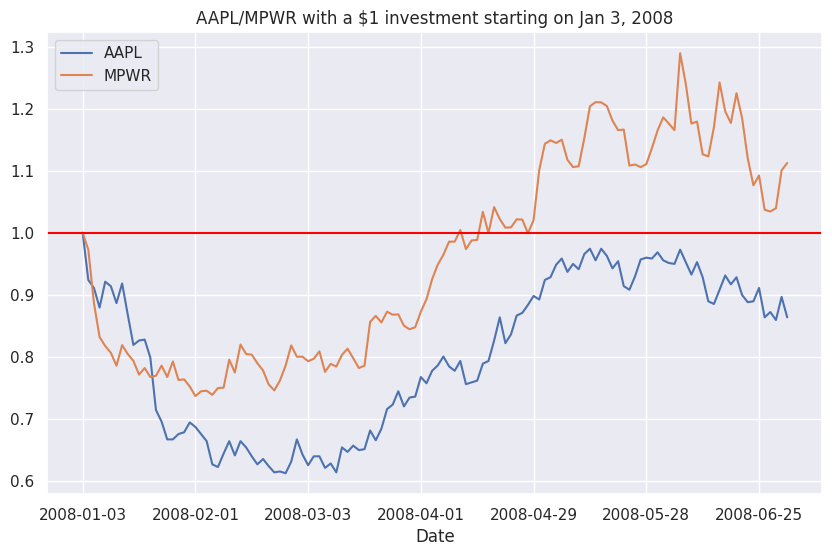

In [31]:

holding_ret_aapl = calc_holding_return(close_prices_df=close_prices_df, symbol='AAPL', start_ix=d2008_start_ix,
                                       end_ix=d2008_start_ix + lookback_window, holding=1)
holding_ret_mpwr = calc_holding_return(close_prices_df=close_prices_df, symbol='MPWR', start_ix=d2008_start_ix,
                                       end_ix=d2008_start_ix + lookback_window, holding=1)

plot_df = pd.concat([holding_ret_aapl, holding_ret_mpwr], axis=1)

plot_df.plot(grid=True, title=f'AAPL/MPWR with a $1 investment starting on Jan 3, 2008', figsize=(10, 6))
plt.axhline(y=1, color='red')

pair_stats_2007 = pairs_selection.stationary_analysis(start_ix=0, end_ix=lookback_window, pair=aapl_mpwr_pair)

<p>
In the case of the AAPL and MPWR pair, in the
half-year trading period starting in January 1, 2003 (2008-01-03) the pair is not mean reverting. The ADF results are shown
below
</p>
<pre>
(AAPL,MPWR)
adf: -2.1617
1%: -3.4837793736959997, 5%: -2.88495387648, 10%: -2.579256976
</pre>
<p>
The ADF value is greater than all of the confidence intervals (1%, 5% and 10%). As a result, it can be concluded that the
AAPL, MPWR pair is not mean reverting in this time period.
</p>
<p>
For the half-year period starting on Jan 3, 2007 the AAPL/MPWR pair is mean reverting with a correlation of about 0.85.
Here the ADF value is less than the 1% confidence interval, suggesting mean reversion with high confidence.
</p>
<pre>
(AAPL,MPWR)
adf: -3.6244
1%: -3.4865346059036564, 5%: -2.8861509858476264, 10%: -2.579896092790057
</pre>

In [32]:
holding_ret_aapl = calc_holding_return(close_prices_df=close_prices_df, symbol='AAPL', start_ix=0,
                                       end_ix=lookback_window, holding=1)
holding_ret_mpwr = calc_holding_return(close_prices_df=close_prices_df, symbol='MPWR', start_ix=0,
                                       end_ix=lookback_window, holding=1)

plot_df = pd.concat([holding_ret_aapl, holding_ret_mpwr], axis=1)


<p>
The plot below $1 invested in AAPL/MPWR over the half-year period starting on Jan 3, 2007.
</p>

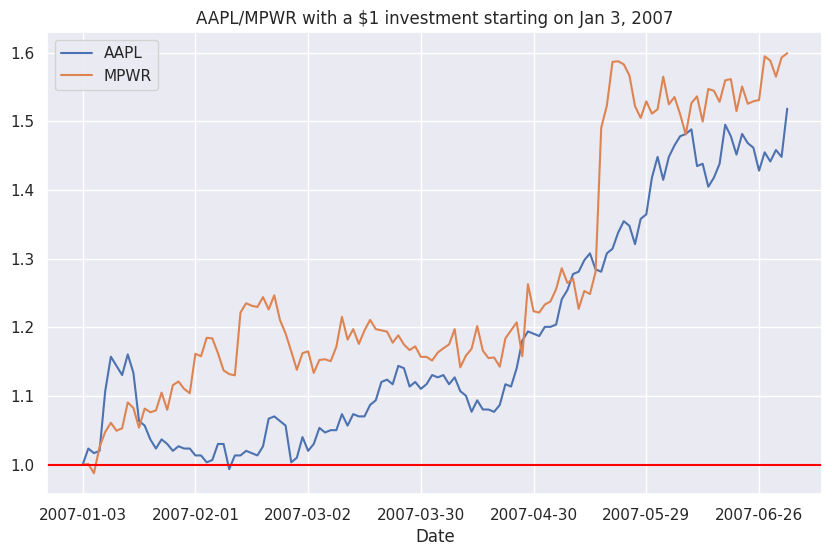

In [33]:

plot_df.plot(grid=True, title=f'AAPL/MPWR with a $1 investment starting on Jan 3, 2007', figsize=(10, 6))
plt.axhline(y=1, color='red')


<h3>
Relationship Between Correlation and Mean Reversion
</h3>



<h3>
Linear Regression and Mean Reversion
</h3>
<p>
The plot below shows the linear regression between AAPL and MPWR in a period where they are highly correlated. The band in the regression
plot represents the 95% confidence interval for the regression line.
</p>

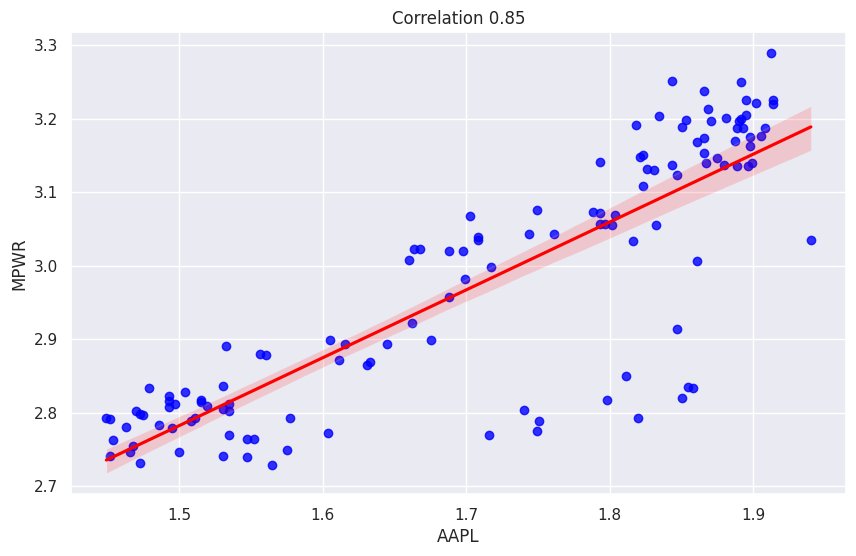

In [34]:
log_pair_df = pd.concat([log_aapl_s, log_mpwr_s], axis=1)

# https://seaborn.pydata.org/tutorial/regression.html
s = sns.regplot(x=log_pair_df.columns[0], y=log_pair_df.columns[1], data=log_pair_df, scatter_kws={"color": "blue"},
                line_kws={"color": "red"})
s.figure.set_size_inches(10, 6)
s.set(title=f'Correlation {aapl_mpwr_cor}')
plt.show()

In [35]:


stats_l = pairs_selection.select_pairs(start_ix=0, end_ix=lookback_window, pairs_list=pairs_list, threshold='1%')

print(f'Number of candidate pairs: {len(pairs_list)}, number of pairs after selection: {len(stats_l)}: {round((len(stats_l) / len(pairs_list)) * 100, 2)} percent')

cor_l = [stat.cor_v for stat in stats_l]
cor_a = np.array(cor_l)


Number of candidate pairs: 8863, number of pairs after selection: 72: 0.81 percent


<p>
The histogram below shows the number of pairs with a correlation greater than or equal to 0.75 in the first time period
(e.g., start_date to start_date + lookback_window).
</p>

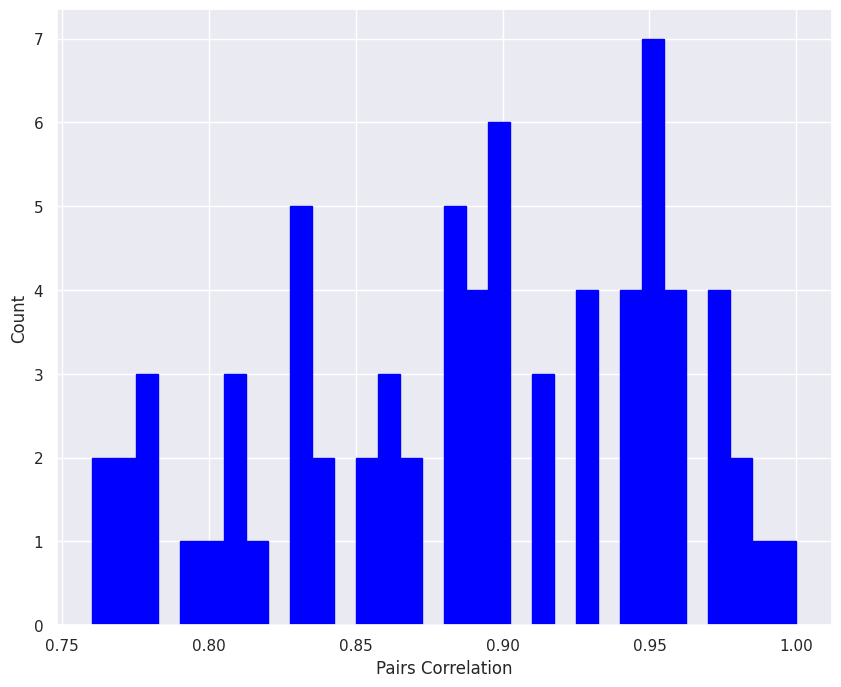

In [36]:

display_histogram(cor_a, 'Pairs Correlation', 'Count')


<h3>
Cointegration
</h3>
<p>
Pairs trading relies on stocks that are mean reverting. When these stocks move outside of their mean, they will revert to the mean.
By taking long and short positions in the pair, it is possible to profit from this mean reversion.
Stocks with high correlation are not necessarily mean reverting.
</p>
<p>
Stocks that are cointegrated (a term coined by Engle and Granger) show mean reversion.
</p>
<p>
There are two common cointegration tests:
</p>
<ul>
<li>
Engle-Granger (linear regression apporach).
</li>
<li>
Johansen
</li>
</ul>
<p>
Engle-Granger (or simply the Granger test) is easier to understand and is used in this notebook.
</p>


<h2>
References
</h2>
<ol>
<li>
<i>Pairs Trading: Quantitative Method and Analysis</i> by Ganapathy Vidyamurthy, 2004, Wiley Publishing
</li>
<li>
Algorithmic Trading: Winning Strategies and Their Rationale by Ernie Chan, 2013, Wiley Publishing
</li>
<li>
<a href="https://medium.com/@financialnoob/granger-causality-test-in-pairs-trading-bf2fd939e575">Granger causality test in pairs trading</a> by
Alexander Pavlov (behind the Medium paywall)
</li>
<li>
<a href="https://letianzj.github.io/cointegration-pairs-trading.html">Quantitative Trading and Systematic Investing by Letian Wang</a> This
post includes a discussion on how the results of Johansen cointegration can be interpreted.
</li>
<li>
<a href="https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb.html">Introduction to Pairs Trading</a> by Delaney Mackenzie and Maxwell Margenot
</li>
<li>
<p>
<a href="https://quantdevel.com/pdf/betterHedgeRatios.pdf">Better Hedge Ratios for Spread Trading</a>, by Paul Teetor, November 2011
</p>
<p>
This note discusses the problem of using ordinary least squares to produce a hedge ratio.
</p>
</li>
<li>
<a href="http://jonathankinlay.com/2019/02/pairs-trading-part-2-practical-considerations/">Pairs Trading – Part 2: Practical Considerations</a> by Jonathan Kinlay
</li>
<li>
<a href="https://www.quantconnect.com/tutorials/strategy-library/intraday-dynamic-pairs-trading-using-correlation-and-cointegration-approach">Intraday Dynamic Pairs Trading using Correlation and Cointegration</a>
</li>
<li>
<a href="https://bsic.it/pairs-trading-building-a-backtesting-environment-with-python/">Pairs Trading: building a backtesting environment with Python</a>
</li>
<li>
<a href="https://www.sciencedirect.com/science/article/pii/S037843712100964X">Applying Hurst Exponent in pair trading strategies
on Nasdaq 100 index</a>
by Quynh Bui and Robert Ślepaczuk
</li>
<li>
<a href="https://www.sciencedirect.com/science/article/pii/S2214845021000880">Pairs trading: is it applicable to exchange-traded funds?</a>
</li>
<li>
<a href="https://hudsonthames.org/an-introduction-to-cointegration/">An Introduction to Cointegration for Pairs Trading By Yefeng Wang</a>
</li>
<li>
<a href="https://www.tradelikeamachine.com/blog/cointegration-pairs-trading/part-1-using-cointegration-for-a-pairs-trading-strategy"><i>Using Cointegration for a Pairs Trading Strategy</i> Martyn Tinsley</a>
</li>

<li>
<a href="https://robotwealth.com/practical-pairs-trading/">Pairs Trading on the Robot Wealth blog by Kris Longmore</a>
</li>
</ol>